(quickstart)=
# Quickstart with the single-resonator solver

## Parameters initialization

First, we need to import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120
import numpy as np
import sys,os
my_PyCore_dir = os.path.dirname('/Users/aleksandrtusnin/Documents/Projects/PyCORe/')
sys.path.append(my_PyCore_dir)
import PyCORe_main as pcm
from scipy.constants import c, hbar
%matplotlib widget

Then, we define the dispersion parameters:
* Number of frequency modes used in the simulations
* Array of comb indexes $\mu$


In [2]:
Num_of_modes = 2**9
mu = np.arange(-Num_of_modes/2,Num_of_modes/2)

* Group velocity dispersion $D_2 = -\beta_2 \frac{D_1^2 c}{n_g}$ [$2\pi$Hz], where $D_1 = 2\pi FSR$

In [3]:
D2 = 4.1e6*2*np.pi

that then defines the integrated dispersion profile $D_\mathrm{int} = D_2 \frac{\mu^2}{2}$

In [4]:
Dint = (mu**2*D2/2) 

:::{admonition} Note: higher order dispersion terms
:class: tip, dropdown
To take into account higher order dispersion orders, you just need to define $D_3,\, D_4,...$
and redefine $D_\mathrm{int} = D_2 \frac{\mu^2}{2} + D_3 \frac{\mu^3}{3!} + D_4 \frac{\mu^4}{4!} + ...$
:::

:::{admonition} Note: mode crossings
:class: tip, dropdown
Mode crossings can be added manually in the dispersion array as follows
```python
mu_AMX = 35
Dint[mu_AMX]-=2*np.pi*1e6
```
In this example, we shifted the mode $\mu=35$ by $1$ GHz below the 'unperturbed' dispersion curve
:::


Then, we create a dictionary with the physical parameters

In [5]:
PhysicalParameters = {'n0' : 1.9,
                      'n2' : 2.4e-19,### m^2/W
                      'FSR' : 181.7e9 ,
                      'w0' : 2*np.pi*192e12,
                      'width' : 1.5e-6,
                      'height' : 0.85e-6,
                      'kappa_0' : 50e6*2*np.pi,
                      'kappa_ex' : 50e6*2*np.pi,
                      'Dint' : Dint,
                      'Raman time' :  1e-15 #s
                      }

Further, we define the pump laser parameters, such as pump power, tuning range, and the scan time. We define the pump in the frequency domain within *fftshift* framework.   

In [6]:
dNu_ini = -1e9 #Hz
dNu_end = 3e9 #Hz
nn = 2000
dOm = 2*np.pi*np.linspace(dNu_ini,dNu_end,nn)
scan_time = 1e-6 #s
P0 = 0.15### W
Pump = np.zeros(len(mu),dtype='complex')
Pump[0] = np.sqrt(P0)

Finally, we define the simulation parameters

In [7]:
simulation_parameters = {'slow_time' : scan_time,
                         'detuning_array' : dOm,
                         'noise_level' : 1e-9,
                         'output' : 'map',
                         'absolute_tolerance' : 1e-10,
                         'relative_tolerance' : 1e-6,
                         'max_internal_steps' : 2000}

:::{admonition} simulation_parameters note
:class: tip, dropdown
* 'noise_level' defines the amplitude of the white noise in the frequency domain;
* 'output' : 'map' defines the dense output from the solver: the result will be np.array(\[dOm.size,mu.size\],dtype=complex). Alternative paramet is 'fin_res', that results only in the output of the final state at dOm[-1].
* 'absolute_tolerance', 'relative_tolerance', and 'max_internal_steps' define the condition for the step-adaptative solver
:::

## Class initialization

Now, we need to initialize the resonator class from the Physical parameters

In [8]:
single_ring = pcm.Resonator()
single_ring.Init_From_Dict(PhysicalParameters)

## Simulations

We are ready to run our simulations

In [9]:
map2d = single_ring.Propagate_PseudoSpectralSAMCLIB(simulation_parameters, Pump,dt=0.5e-3)

Normalized pump power $f_0^2$ = 33.0
Normalized detuning $\zeta_0$ = [-20.000000000000004,60.0]
Pseudo Spectral Step adaptative Dopri853 with Raman from NR3 is running
In val_RE = 0.00055806
Initialization started
Initialization succesfull
100% [||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||]

:::{admonition} Simulations print output
:class: tip, dropdown
* For convinience, normalized pump power $f_0^2$ and the detuning array $\zeta_0$ are printed before the execution. 
* Third line specifies the type of the solver that is used
* 4th and 5th lines reflect the building of the solver class
* 6th line represnts the progress bar
:::

## Data analysis

Now the simulation results are storred in the array map2d that has the size \[dOm.size $\times$ mu.size \] and contains the amplitude and the phase of the optical field envelope. Number of photons, storred in the cavity, defined as 
```python
np.sum(map2d,axis=1)/Num_of_modes
```
while number of modes for a comb line $\mu$ is
```python
map2d[:,mu]/Num_of_modes
```

### Transmission trace
Dynamcis of the number of modes as detuning function presented below

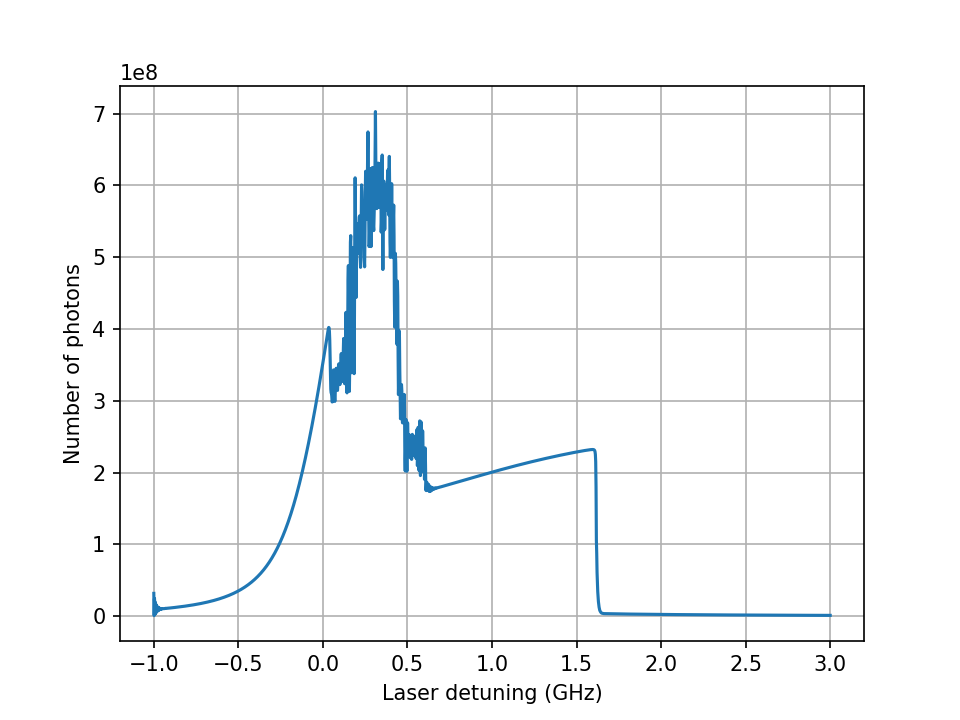

In [10]:
Num_of_photons = np.sum(np.abs((map2d[:,:])/(Num_of_modes))**2,axis=1)
fig = plt.figure(frameon=False,dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(dOm/2/np.pi/1e9,Num_of_photons)
ax.set_xlabel('Laser detuning (GHz)')
ax.set_ylabel('Number of photons')
ax.grid(True)
plt.show()

Transmission trace through the resonator can be obtained via
$$
S_\mathrm{out} = S_\mathrm{in} - \sqrt{\kappa_\mathrm{ex}}A,
$$
where $S_\mathrm{in}^2 = P_\mathrm{in}/\hbar\omega$ to $\mu$-th comb line and $A =$ map2d\[:,mu\]/Num_of_modes.

Below we show the simulated transmission trace that should be visible on a photodetector

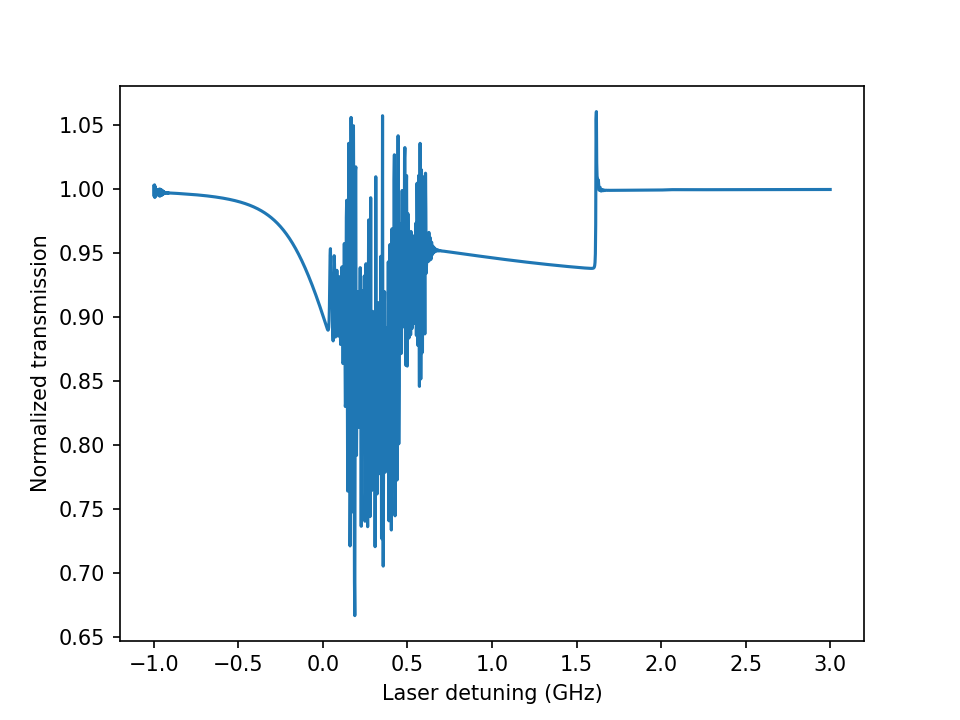

In [11]:
Sin = Pump/np.sqrt(hbar*PhysicalParameters['w0'])
Sout = np.zeros_like(map2d)
Sout = Sin - np.sqrt(single_ring.kappa_ex)*map2d/Num_of_modes
fig = plt.figure(frameon=False,dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(dOm/2/np.pi/1e9,np.sum(abs(Sout)**2,axis=1)/abs(Sin[0])**2)
ax.set_xlabel('Laser detuning (GHz)')
ax.set_ylabel('Normalized transmission')
plt.show()


### Optical spectrum
A simulated OSA spectrum for a given detuning can be presented as

:::{admonition} Note
:class: tip, dropdown
$|S_\mathrm{out}|^2\hbar\omega$ is measured in Watts, so to present it in dBm is pretty straightforward
$$
\mathrm{Spectrum [dBm ]} = 10log_{10}(|S_\mathrm{out}|^2\hbar\omega/10^{-3})
$$
:::


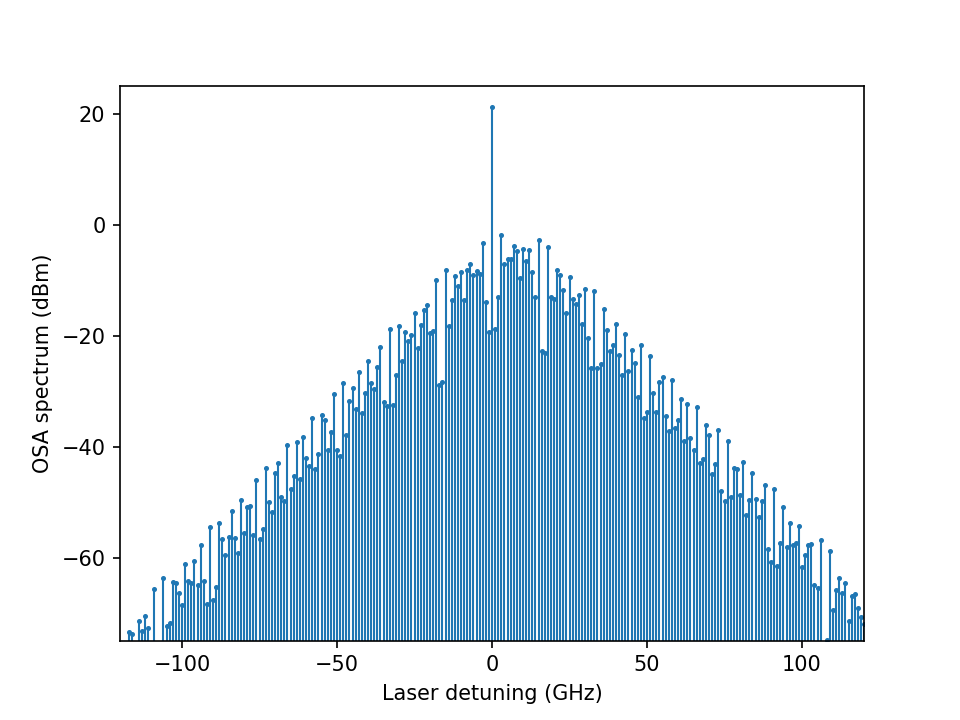

In [12]:
fig = plt.figure(frameon=False,dpi=150)
ax = fig.add_subplot(1,1,1)
ax.vlines(mu,-300,10*np.log10(np.abs(np.fft.fftshift(Sout[1000,:]))**2*hbar*PhysicalParameters['w0']/1e-3),lw=1.0)
ax.scatter(mu,10*np.log10(np.abs(np.fft.fftshift(Sout[1000,:]))**2*hbar*PhysicalParameters['w0']/1e-3),s=2.0)
ax.set_xlabel('Laser detuning (GHz)')
ax.set_ylabel('OSA spectrum (dBm)')
ax.set_ylim(-75,25)
ax.set_xlim(-120,120)
plt.show()

### Quick dynamics plot
To quickly analyze the generated data, we implemeted an interactive function *Plot_map* that allows for investigation of the field with different detuings

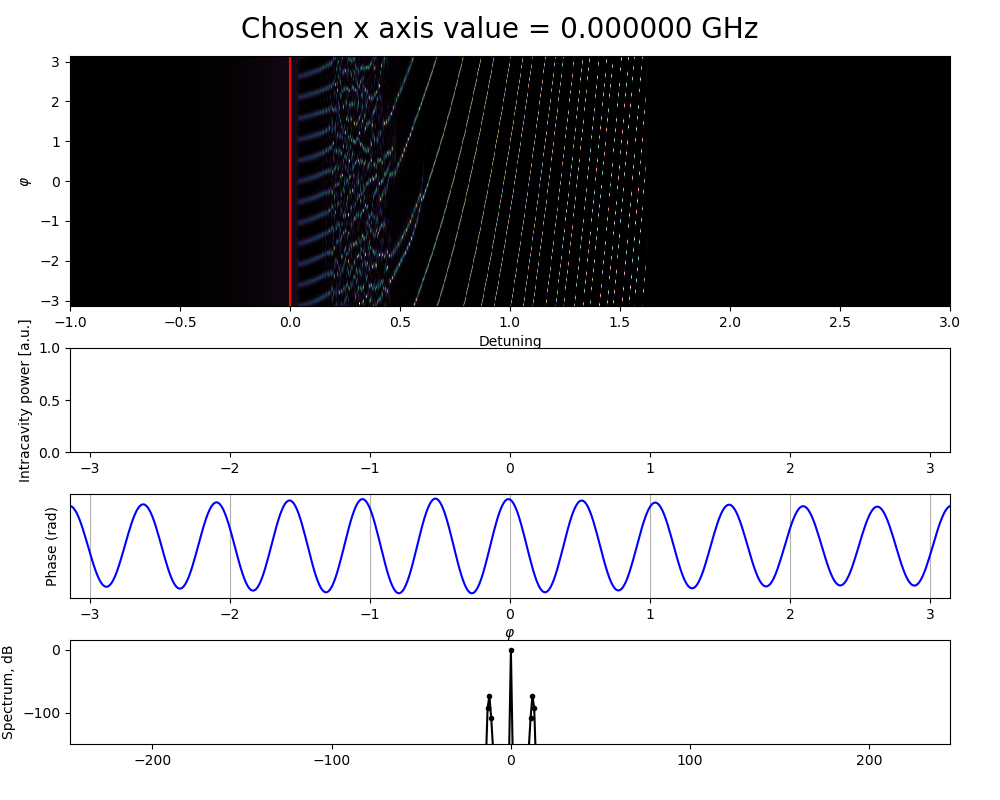

In [13]:
pcm.Plot_Map(np.fft.ifft(map2d,axis=1),dOm/2/np.pi/1e9,xlabel='Detuning', units='GHz')